In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
input_dir = 'input'
print(os.listdir(input_dir))

['sample_submission.csv', 'train_identity.csv', 'train_transaction.csv']


In [19]:
from sklearn import preprocessing
import xgboost as xgb
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
import matplotlib.pyplot as plt
import imblearn #for SMOTE
from sklearn.decomposition import PCA, KernelPCA

In [20]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
#         else:
#             df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

Wall time: 0 ns


In [13]:
%%time
def train_xgb(trainx,trainy):
    clf = xgb.XGBClassifier(n_estimators=500,
                        n_jobs=-1,
                        max_depth=9,
                        learning_rate=0.05,
                        subsample=0.9,
                        colsample_bytree=0.9,
                        missing=-999,
                        #tree_method='gpu_hist'
                        )

    clf.fit(trainx,trainy)
    return clf
from sklearn.linear_model import LogisticRegression

def train_logistic(trainx,trainy):
    lr=LogisticRegression(max_iter=10000)
    lr.fit(X_train,y_train)
    return lr

Wall time: 0 ns


In [40]:
#Plotting
from sklearn.metrics import auc
def plot_pre_curve(y_test,probs):
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
#     fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
    auc_pr = auc(recall,precision)
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.')
    plt.title("precision recall curve "+str(auc_pr))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the plot
    plt.show()
    
def plot_roc(y_test,probs):
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("ROC curve "+str(roc_auc_score(y_test,probs)))
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    # show the plot
    plt.show()

In [35]:
def predict_plot(model):
    print(y_test.shape,X_test.shape)
    predictions =model.predict_proba(X_test)[:,1]
    print(predictions)
    plot_pre_curve(y_test,predictions)
    plot_roc(y_test,predictions)


In [21]:
%%time
train_transaction = pd.read_csv(input_dir+'/train_transaction.csv', index_col='TransactionID',nrows=60000)
# test_transaction = pd.read_csv(input_dir+'/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv(input_dir+'/train_identity.csv', index_col='TransactionID')
# test_identity = pd.read_csv(input_dir+'/test_identity.csv', index_col='TransactionID')

sample_submission = pd.read_csv(input_dir+'/sample_submission.csv', index_col='TransactionID')

Wall time: 4.51 s


In [22]:
%%time
from sklearn.model_selection import train_test_split

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
# test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
train = train.fillna(-999)
# m_features = 
train = reduce_mem_usage2(train)

print(train.shape)
# print(test.shape)

y_train = train['isFraud'].copy()

X_train,X_test,y_train,y_test=train_test_split(train.drop('isFraud',axis=1),y_train,test_size=.2,random_state=1)

# Drop target, fill in NaNs
# X_train = train.drop('isFraud', axis=1)
# X_test = test.copy()


Memory usage of dataframe is 201.17 MB
Memory usage after optimization is: 65.96 MB
Decreased by 67.2%
(60000, 433)
Wall time: 19.8 s


In [23]:
# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))   

In [27]:
def pca_vcols(all_data):
    vcols = [f'V{i}' for i in range(1,340)]
    sc = preprocessing.MinMaxScaler()

    pca = PCA(n_components=2) #0.99
    vcol_pca = pca.fit_transform(sc.fit_transform(all_data[vcols].fillna(-1)))

    all_data['_vcol_pca0'] = vcol_pca[:,0]
    all_data['_vcol_pca1'] = vcol_pca[:,1]
    all_data['_vcol_nulls'] = all_data[vcols].isnull().sum(axis=1)

    all_data.drop(vcols, axis=1, inplace=True)
pca_vcols(X_train)
pca_vcols(X_test)

In [11]:
# def deleteStartingWith(df,prefix):
#     cols= df.loc[:, df.columns.str.startswith(prefix)]
#     del cols
#     del df[[col for col in df if col.startswith(prefix)]]
# deleteStartingWith(X_train,'M')
# deleteStartingWith(X_test,'M')
# deleteStartingWith(X_train,'D')
# deleteStartingWith(X_test,'D')

# del X_test[[col for col in X_train if col.startswith('M')]]

In [12]:
from imblearn.over_sampling import SMOTE
#ratio='minority'
smote = SMOTE(n_jobs=8,sampling_strategy='minority')
X_sm, y_sm = smote.fit_sample(X_train, y_train)
X_sm.shape,y_sm.shape,X_train.shape

((93374, 96), (93374,), (48000, 96))

In [28]:
X_train.columns

Index(['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
       'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2',
       'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
       'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3',
       'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14',
       'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_01',
       'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09',
       'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17',
       'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo',
       '_vcol_pca0', '_vcol_pca1', '_vcol_nulls'],
      dtype='object')

In [29]:
%%time
clf = train_xgb(X_train, y_train)
# clf = train_logistic(X_train,y_train)

Wall time: 1min 18s


(12000,) (12000, 96)
[0.00014227 0.00026397 0.00577206 ... 0.00422423 0.00051352 0.00086302]


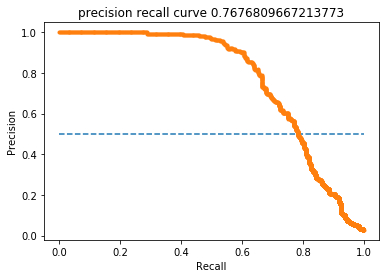

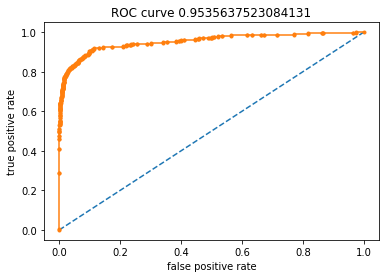

In [42]:
# clf.predict_proba(X_test)
predict_plot(clf)

In [31]:
%%time
clf_smote = train_xgb(X_sm,y_sm)

Wall time: 2min 53s


(12000,) (12000, 96)
[0.00064787 0.00170394 0.0667025  ... 0.00189745 0.00144273 0.0011741 ]


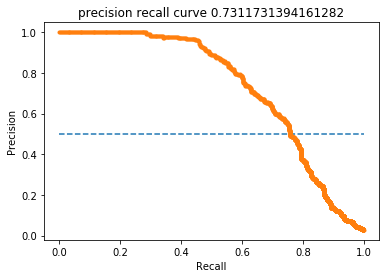

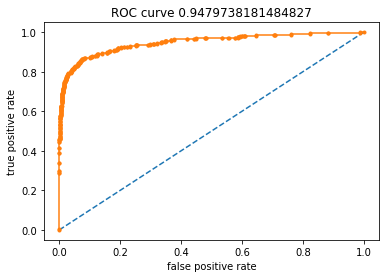

In [41]:
predict_plot(clf_smote)

In [ ]:
# sample_submission['isFraud'] = clf.predict_proba(X_test)[:,1]
# sample_submission.to_csv('simple_xgboost.csv')

def train_and_evaluate(X_train,y_train,X_test,y_test):
    clf = xgb.XGBClassifier(n_estimators=500,
                        n_jobs=4,
                        max_depth=9,
                        learning_rate=0.05,
                        subsample=0.9,
                        colsample_bytree=0.9,
                        missing=-999)

    clf.fit(X_train, y_train)
    print(y_test.shape,X_test.shape)
    predictions =clf.predict(X_test)
    plot_pre_curve(y_test,predictions)
    plot_roc(y_test,predictions)